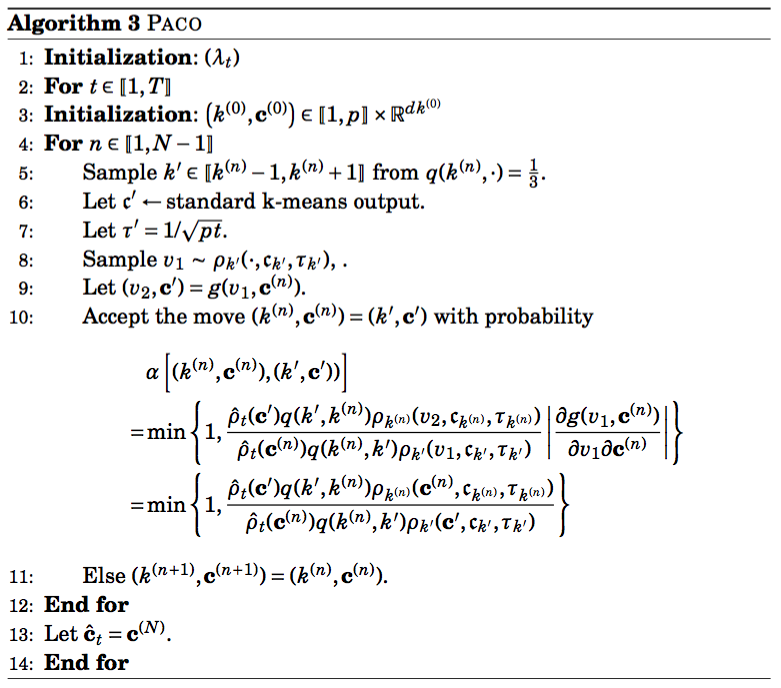

In [1]:
from IPython.display import Image
Image(filename='Algo.png')

### PACBO implementation on python

In [2]:
import pandas as pd
import numpy as np
from random import randint
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from math import *
from scipy.stats import gamma
import scipy.special as sp
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
### Funtions needed

# Student's T random variable
def multivariate_t_rvs(m, S, df=np.inf, n=1):
    '''generate random variables of multivariate t distribution
    Parameters
    ----------
    m : array_like
        mean of random variable, length determines dimension of random variable
    S : array_like
        square array of covariance  matrix
    df : int or float
        degrees of freedom
    n : int
        number of observations, return random array will be (n, len(m))
    Returns
    -------
    rvs : ndarray, (n, len(m))
        each row is an independent draw of a multivariate t distributed
        random variable
    '''
    m = np.asarray(m)
    d = len(m)
    if df == np.inf:
        x = 1.
    else:
        x = np.random.chisquare(df, n)/df
    z = np.random.multivariate_normal(np.zeros(d),S,(n,))
    return m + z/np.sqrt(x)[:,None]   # same output format as random.multivariate_normal


def multivariate_t_distribution(x, mu, Sigma, df):
    '''
    Multivariate t-student density. Returns the density
    of the function at points specified by x.

    input:
        x = parameter (n-d numpy array; will be forced to 2d)
        mu = mean (d dimensional numpy array)
        Sigma = scale matrix (dxd numpy array)
        df = degrees of freedom

    Edited from: http://stackoverflow.com/a/29804411/3521179
    '''

    x = np.atleast_2d(x) # requires x as 2d
    nD = Sigma.shape[0] # dimensionality
    numerator = sp.gamma(1.0 * (nD + df) / 2.0)
    denominator = (sp.gamma(1.0 * df / 2.0) * np.power(df * np.pi, 1.0 * nD / 2.0) * np.power(np.linalg.det(Sigma), 1.0 / 2.0) * np.power(1.0 + (1.0 / df) * np.diagonal( np.dot( np.dot(x - mu, np.linalg.inv(Sigma)), (x - mu).T)), 1.0 * (nD + df) / 2.0))
    
    return 1.0 * numerator / denominator 

# Cumulative loss function
def cumulative_loss(centers, observations):
    d = observations.shape[1]
    lth_centers = len(centers)
    size_obs = len(observations)
    C_mtx = np.array([centers for i in range(size_obs)])
    Data_mtx = []
    for i in range(size_obs):
        Data_mtx.append(np.reshape(np.repeat(observations[i,:], lth_centers), newshape=(-1, lth_centers)).transpose())
    Data_mtx = np.array(Data_mtx)
    Diff = np.sum((C_mtx - Data_mtx)**2, axis=-1)
    return sum(np.min(Diff,axis = 1))

# Transition probability function
def transition_probability(x, z, K_max, prob = 1/3):
    x = int(x)
    z = int(z)
    K_max = int(K_max)
    if (x > K_max) or (z > K_max) or (x < 1) or (z < 1):
        q = 0
    elif x == 1:
        q = .5*int((z == 1) or (z == 2))
    elif x == K_max:
        q = 0.5*int((z == K_max) or (z == (K_max-1)))
    elif x == z:
        q = prob
    else:
        q = (1-prob)/2 * int(( x < z and z < (x+2)) or (z < x and z > (x-2)))
    return q

# Function to get clusters labels from centroids
def labels_function(centers, observations):
    if centers.ndim == 1:
        centers = np.matrix(centers)
    d = observations.shape[1]
    lth_centers = centers.shape[0]
    size_obs = len(observations)
    C_mtx = []
    for i in range(size_obs):
        C_mtx.append(centers)
    C_mtx = np.array(C_mtx)
    Data_mtx = []
    for i in range(size_obs):
        Data_mtx.append(np.reshape(np.repeat(observations[i,:], lth_centers), newshape=(-1, lth_centers)).transpose())
    Data_mtx = np.array(Data_mtx)
    Diff = np.sum((C_mtx - Data_mtx)**2, axis=-1)
    return np.apply_along_axis(lambda x: np.where(x==min(x)), 1, Diff).ravel()

# Function for the prior
def runiform_ball(n, d, R):
    simulations = []
    for i in range(n):
        simul = np.random.uniform(low=-R, high=R, size=d)
        while np.sqrt(sum(simul**2))>R:
            simul = np.random.uniform(low=-R, high=R, size=d)
        simulations.append(simul)
    return np.array(simulations)

# Function for the instantaneous loss
def instantaneous_loss(centers, instant_observation):
    centers = np.matrix(centers) #Delete this line
    replicate_instant_observation = np.reshape(np.matrix(np.repeat(instant_observation, len(centers))), newshape=(-1,len(centers))).transpose()
    distances = np.power(centers - replicate_instant_observation, 2).sum(axis=1)
    return np.min(distances)

In [4]:
def PACO(X, R, coeff = 2, K_max = 50, N_iterations = 500, cluster_plot = False, axis_plot = (0,1)):
    
    d = X.shape[1]
    T = len(X)
    multiplier_R = 1.5
    sum_loss = np.repeat(0., N_iterations)
    
    # IF 
    
    log_prob_acceptance = [0]
    nb_of_clusters = [1]
    pred_centers = []
    labels = [np.array([0])]
    predicted_loss = np.repeat(0., T)
    #predicted_loss_good = []##
    proposal_loss = np.repeat(0., T)
    
    lambda_1 = np.array([1] + [2.5*coeff*(d+2)*(t-1)**(-0.5)/R for t in range(2,T+1)])
    lambda_2 = np.array([(d+2)*(t)**(-0.5)/(multiplier_R * R)**4 for t in range(1,T+1)])
    
    c_1 = runiform_ball(5000, d, multiplier_R*R)
    
    index_1 = np.array(np.power(c_1 - np.reshape(np.matrix(np.repeat(X[0], 5000)), newshape=(-1,5000)).transpose(), 2).sum(axis=1)).ravel()
    index_1 = np.where(index_1 == instantaneous_loss(c_1, X[0]))[0][0]
    pred_centers.append(np.matrix(c_1[index_1]))
    predicted_loss[0] = instantaneous_loss(pred_centers[0], X[0])
    
    #predicted_loss_good.append(instantaneous_loss(pred_centers[0], X[0]))##
    
    for t in range(2,T+1): # t va de 2 à 10
        print(t/T)
        parameter_means_proposal = []
        Niter_centers = []
        Nclusters = []
        
        tau_proposal = (K_max*t*d)**(-0.5)
        
        Nclusters.append(nb_of_clusters[t-2])
        kmeans = KMeans(n_clusters=Nclusters[0], random_state=0, max_iter=10).fit(X[:t-1])
        parameter_means_proposal.append(kmeans.cluster_centers_)
        
        Niter_centers.append(np.apply_along_axis(lambda x: multivariate_t_rvs(x, np.diag([tau_proposal for i in range(d)]), df=3, n=1)[0], 1, parameter_means_proposal[0]))

        while sum(np.sqrt(np.sum(np.power(Niter_centers[0],2),axis = 1)) > multiplier_R * R) > 0:
            Niter_centers[0] = np.apply_along_axis(lambda x: multivariate_t_rvs(x, np.diag([tau_proposal for i in range(d)]), df=3, n=1)[0], 1, parameter_means_proposal[0])


        proposal_loss[:t-1] = list(np.apply_along_axis(lambda x: instantaneous_loss(Niter_centers[0], x), 1, X[:t-1]))
        
        sum_loss[0] = sum(proposal_loss[:(t-1)]) + 0.5 * sum(lambda_2 * (proposal_loss - predicted_loss)**2)
        
        for n in range(2,N_iterations+1): # n va de 2 à 500
            proposal_loss_temp = np.repeat(0., T)
            transition_prob = np.array([transition_probability(Nclusters[n-2],Nclusters[n-2]-1,K_max), transition_probability(Nclusters[n-2],Nclusters[n-2],K_max), transition_probability(Nclusters[n-2],Nclusters[n-2]+1,K_max)])
            transition_prob = transition_prob/sum(transition_prob)
            new_k = np.random.choice([Nclusters[n-2]-1,Nclusters[n-2],Nclusters[n-2]+1], p=transition_prob)
            
            if new_k == Nclusters[n-2]:
                m_t = parameter_means_proposal[n-2]
            else:
                if new_k >= t-1:
                    new_k = t-1
                    m_t = X[:t-1]
                else:
                    kmeans = KMeans(n_clusters=int(new_k), random_state=0, max_iter=10).fit(X[:t-1])
                    m_t = kmeans.cluster_centers_
            c_k_prime = np.apply_along_axis(lambda x: multivariate_t_rvs(x, np.diag([tau_proposal for i in range(d)]), df=3, n=1), 1, m_t)
            
            if sum(np.sqrt(np.sum(c_k_prime**2, axis = 2)) < multiplier_R * R ) == new_k: 
                log_numerator_prop = np.array([np.log(multivariate_t_distribution(Niter_centers[n-2][x,], parameter_means_proposal[n-2][x,], np.diag([tau_proposal for i in range(d)]), 3)) for x in range(Nclusters[n-2])])
                log_denominator_prop = np.array([np.log(multivariate_t_distribution(c_k_prime[x,], m_t[x,], np.diag([tau_proposal for i in range(d)]), 3)) for x in range(new_k)])    
                
                log_numerator_prior = np.repeat(log(sp.gamma(d/2+1)) - (d/2)*np.log(pi) - d*np.log(multiplier_R*R),new_k)
                log_denominator_prior = np.repeat(log(sp.gamma(d/2+1)) - (d/2)*np.log(pi) - d*np.log(multiplier_R*R),Nclusters[n-2])
                
                ln_division = sum(np.concatenate((log_numerator_prior, log_numerator_prop.ravel())) - np.concatenate((log_denominator_prior, log_denominator_prop.ravel())))
                
                proposal_loss_temp[:t-1] = list(np.apply_along_axis(lambda x: instantaneous_loss(c_k_prime, x), 1, X[:t-1]))
                
                s_loss_prime = sum(proposal_loss_temp) + .5 * sum(lambda_2 * (proposal_loss_temp - predicted_loss)**2)
                
                ln_accept_ratio = (-lambda_1[t-2] * (s_loss_prime-sum_loss[n-2])) + ln_division + np.log(transition_probability(new_k, Nclusters[n-2],K_max)) - np.log(transition_probability(Nclusters[n-2], new_k, K_max))
            else:
                ln_accept_ratio = float('-inf')
            
            bool_ = np.log(np.random.uniform()) < ln_accept_ratio
            
            if bool_:
                Niter_centers.append(np.array(np.matrix(c_k_prime)))
                parameter_means_proposal.append(m_t)
                Nclusters.append(new_k)
                sum_loss[n-1] = s_loss_prime
            else:
                Niter_centers.append(Niter_centers[n-2])
                parameter_means_proposal.append(parameter_means_proposal[n-2])
                Nclusters.append(Nclusters[n-2])
                sum_loss[n-1] = sum_loss[n-2]
        
        log_prob_acceptance.append(ln_accept_ratio)
        nb_of_clusters.append(Nclusters[N_iterations-1])
        pred_centers.append(np.matrix(Niter_centers[N_iterations-1]))
        predicted_loss[t-1] = instantaneous_loss(pred_centers[t-2], X[t-1,])
        labels.append(labels_function(pred_centers[t-1], X[:t,:]))
        
        #intermediate_loss = []##
        #for n in range(t-1):##
        #    intermediate_loss.append(instantaneous_loss(pred_centers[t-2], X[n,]))##
        #predicted_loss_good.append(np.sum(intermediate_loss))##
        
        if cluster_plot:
        # Plot clusters
            plt.scatter(X[:t,axis_plot[0]],X[:t,axis_plot[1]], c=[matplotlib.cm.spectral(float(i) /10) for i in labels_function(pred_centers[t-1], X[:t,:])])
            plt.scatter(np.array(pred_centers[t-1][:,axis_plot[0]]),np.array(pred_centers[t-1][:,axis_plot[1]]), marker="2", c = "green")
            plt.show()
            
    #labels = labels_function(pred_centers[T-1], X)
    return nb_of_clusters, pred_centers, labels, predicted_loss, log_prob_acceptance
    #return [nb_of_clusters[T-1], pred_centers[T-1], labels]

In [37]:
# The X we will use is
data = pd.read_csv('test.csv')
data = data.drop(['Unnamed: 0'], axis = 1)
X = data.as_matrix()
R = np.max(np.sqrt(np.sum(X**2, axis=1)))

0.2


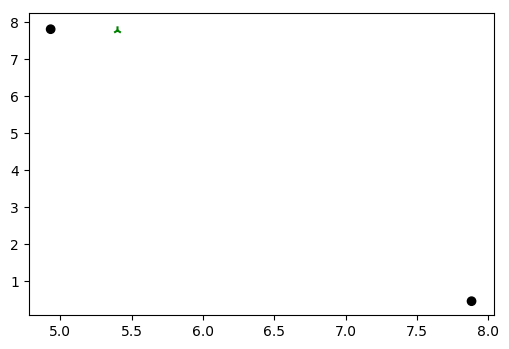

0.3


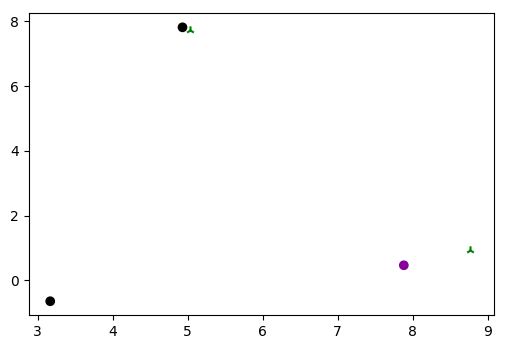

0.4


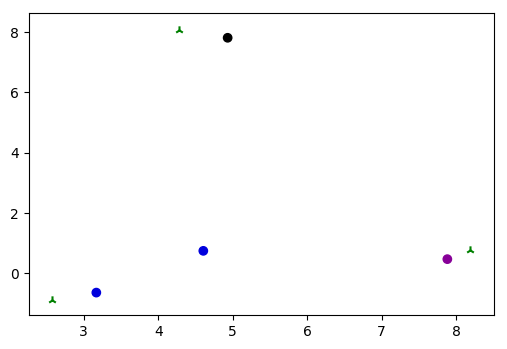

0.5


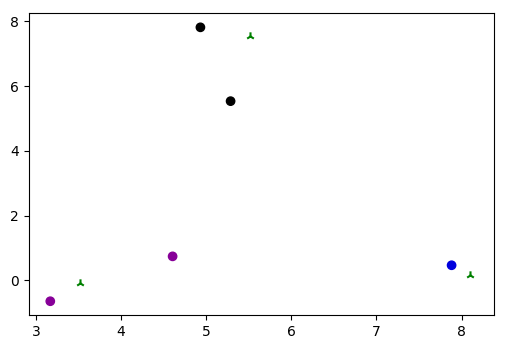

0.6


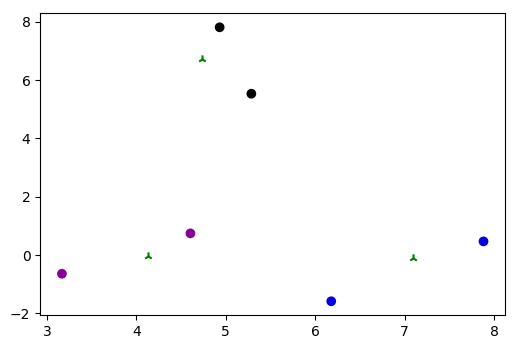

0.7


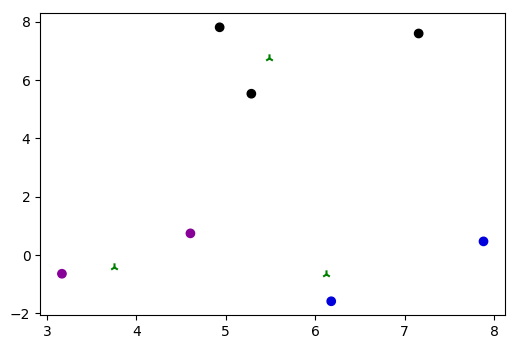

0.8


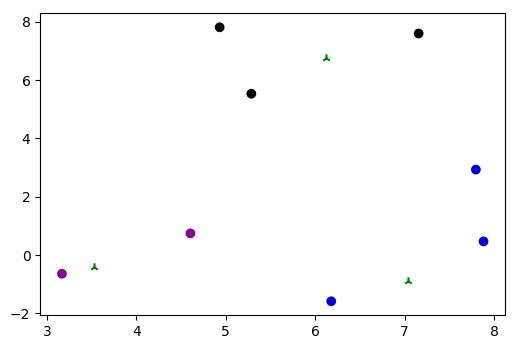

0.9


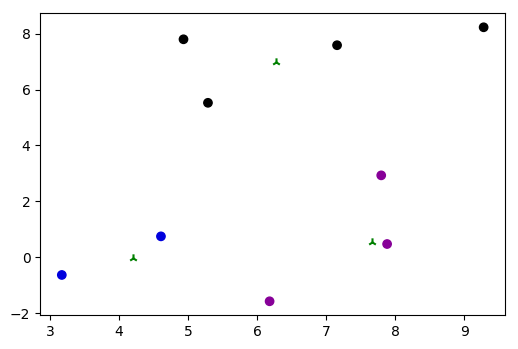

1.0


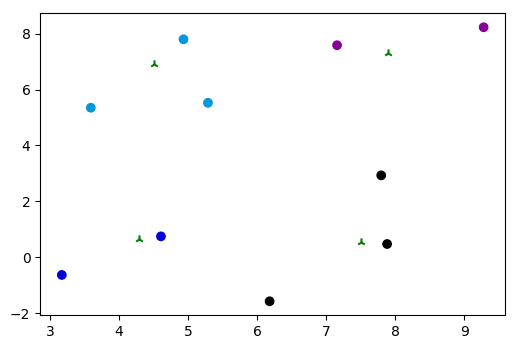

In [38]:
nb_of_clusters, pred_centers, labels, predicted_loss, log_prob_acceptance = PACO(X, R, coeff = 2, K_max = 50, N_iterations = 500, cluster_plot = True, axis_plot = (0,1))

## Numerical experiments

1] - First simulation of 200 points in $R^5$, made of 4 clusters

Be carefull, the following graphs are made using a number of iterations equal to 200. Results would have been more robust if using higher number of iterations (500 is the number suggested in the paper).

In [5]:
## generating 4 clusters of 200 points in R5
Nb = 4
d = 5
T = 200
proportion = np.repeat(1/Nb, Nb)
Mean_vectors = np.random.rand(Nb,d)*20-10
mydata = np.random.multivariate_normal(mean = Mean_vectors[np.random.choice([i for i in range(Nb)], p=proportion)],
                              cov = np.identity(d), size = 1)
for k in range(T-1):
    mydata = np.vstack([mydata, np.random.multivariate_normal(mean = Mean_vectors[np.random.choice([i for i in range(Nb)], p=proportion)],
                              cov = np.identity(d), size = 1)])
R = np.max(np.sqrt(np.sum(mydata**2, axis=1)))

In [7]:
nb_of_clusters_1, pred_centers, labels, predicted_loss_1, log_prob_acceptance = PACO(mydata, R, coeff = 2, K_max = 20, N_iterations = 200, cluster_plot = False, axis_plot = (0,1))

0.01
0.015
0.02
0.025
0.03
0.035
0.04
0.045
0.05
0.055
0.06
0.065
0.07
0.075
0.08
0.085
0.09
0.095
0.1
0.105
0.11
0.115
0.12
0.125
0.13
0.135
0.14
0.145
0.15
0.155
0.16
0.165
0.17
0.175
0.18
0.185
0.19
0.195
0.2
0.205
0.21
0.215
0.22
0.225
0.23
0.235
0.24
0.245
0.25
0.255
0.26
0.265
0.27
0.275
0.28
0.285
0.29
0.295
0.3
0.305
0.31
0.315
0.32
0.325
0.33
0.335
0.34
0.345
0.35
0.355
0.36
0.365
0.37
0.375
0.38
0.385
0.39
0.395
0.4
0.405
0.41
0.415
0.42
0.425
0.43
0.435
0.44
0.445
0.45
0.455
0.46
0.465
0.47
0.475
0.48
0.485
0.49
0.495
0.5
0.505
0.51
0.515
0.52
0.525
0.53
0.535
0.54
0.545
0.55
0.555
0.56
0.565
0.57
0.575
0.58
0.585
0.59
0.595
0.6
0.605
0.61
0.615
0.62
0.625
0.63
0.635
0.64
0.645
0.65
0.655
0.66
0.665
0.67
0.675
0.68
0.685
0.69
0.695
0.7
0.705
0.71
0.715
0.72
0.725
0.73
0.735
0.74
0.745
0.75
0.755
0.76
0.765
0.77
0.775
0.78
0.785
0.79
0.795
0.8
0.805
0.81
0.815
0.82
0.825
0.83
0.835
0.84
0.845
0.85
0.855
0.86
0.865
0.87
0.875
0.88
0.885
0.89
0.895
0.9
0.905
0.91
0.915
0.92
0.9

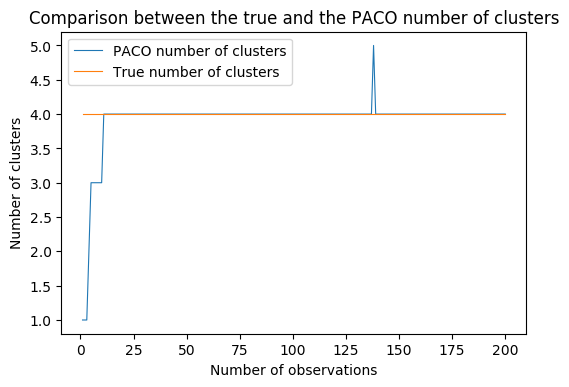

In [9]:
plt.plot([t+1 for t in range(T)], nb_of_clusters_1, label = "PACO number of clusters", linewidth=.8)
plt.plot([t+1 for t in range(T)], np.repeat(4,T), label = "True number of clusters", linewidth=.8)

plt.title('Comparison between the true and the PACO number of clusters')
plt.xlabel('Number of observations')
plt.ylabel('Number of clusters')
plt.legend()

$ECL = \sum\limits_{t=1}^{T}E_{\hat{\rho}_1, \hat{\rho}_2,...,\hat{\rho}_t}l(\hat{c}_t,x_t)$

$OCL = \inf\limits_{c\in \mathcal{C}(k*,R)}\sum\limits_{t=1}^{T}l(c,x_t)$

Le prédicteur Oracle correspond ici au k-means utilisé avec le bon nombre de clusters.

In [10]:
oracle_loss = []
for i in range(T):
    if i < 4:
            kmeans = KMeans(n_clusters=i+1, random_state=0, max_iter=10).fit(mydata[:i+1])
    else:
        kmeans = KMeans(n_clusters=4, random_state=0, max_iter=10).fit(mydata[:i+1])
    centers__ = kmeans.cluster_centers_
    intermediate_loss = []
    for n in range(i):
        intermediate_loss.append(instantaneous_loss(centers__, mydata[n]))
    oracle_loss.append(np.sum(intermediate_loss))

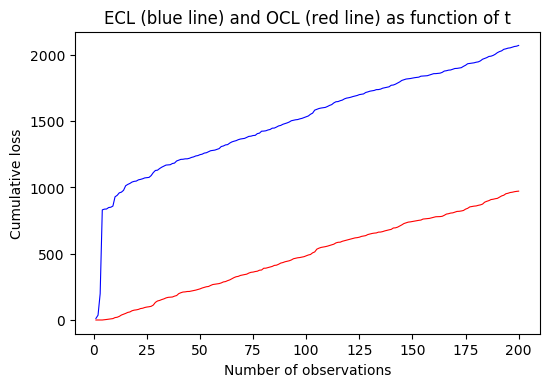

In [12]:
x = [t+1 for t in range(T)]

plt.plot(x, np.cumsum(predicted_loss_1), 'blue', linewidth=.8)
#empirical_upper_band = np.cumsum(predicted_loss_1)+np.array([np.sqrt(np.var(np.cumsum(predicted_loss_1)[:i])) for i in range(T)])
#empirical_lower_band = np.cumsum(predicted_loss_1)-np.array([np.sqrt(np.var(np.cumsum(predicted_loss_1)[:i])) for i in range(T)])
#plt.plot(x, empirical_upper_band, 'blue', linestyle='--', linewidth=.8)
#plt.plot(x, empirical_lower_band, 'blue', linestyle='--', linewidth=.8)
#plt.fill_between(x, empirical_upper_band, empirical_lower_band, color='blue', alpha='0.5')

plt.plot(x, oracle_loss, 'red', linewidth=.8)
#oracle_upper_band = oracle_loss+np.array([np.sqrt(np.var(oracle_loss[:i])) for i in range(T)])
#oracle_lower_band = oracle_loss-np.array([np.sqrt(np.var(oracle_loss[:i])) for i in range(T)])
#plt.plot(x, oracle_upper_band, 'red', linestyle='--', linewidth=.8)
#plt.plot(x, oracle_lower_band, 'red', linestyle='--', linewidth=.8)
#plt.fill_between(x, oracle_upper_band, oracle_lower_band, color='red', alpha='0.5')


plt.title('ECL (blue line) and OCL (red line) as function of t')
plt.xlabel('Number of observations')
plt.ylabel('Cumulative loss')
plt.show()

Recall from Corollary 3 that the difference between the expected cumulative loss (ECL) of Algorithm 2 and the oracle cumulative loss (OCL) is sublinear in T. And here, we can see that the gap between ECL and OCL fills as t grows.

/Users/Linger/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


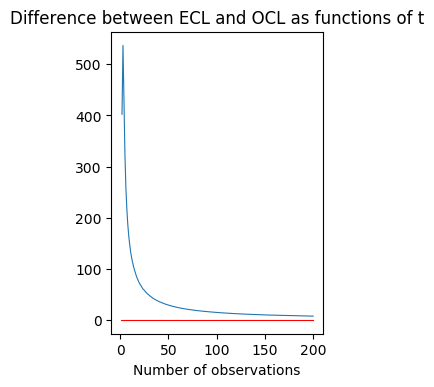

/Users/Linger/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide


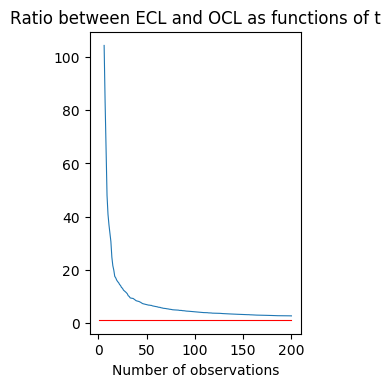

In [118]:
Diff = np.cumsum(predicted_loss_1) - oracle_loss
plt.subplot(1, 2, 1)
plt.plot([t+1 for t in range(T)], [Diff[i]/i for i in range(T)], linewidth=.8)
plt.plot([t+1 for t in range(T)], [0 for i in range(T)], 'red', linewidth=.8)
plt.title('Difference between ECL and OCL as functions of t')
plt.xlabel('Number of observations')
plt.show()

Ratio = np.cumsum(predicted_loss_1)/oracle_loss
plt.subplot(1, 2, 2)
plt.plot([t+1 for t in range(5, T)], [Ratio[i] for i in range(5, T)], linewidth=.8)
plt.plot([t+1 for t in range(T)], [1 for i in range(T)], 'red', linewidth=.8)
plt.title('Ratio between ECL and OCL as functions of t')
plt.xlabel('Number of observations')
plt.show()

The previous remark is pictured in the above figures, where the difference (normalized by t so it converges to 0) and the ratio (which converges to 1) between the mean of ECL and that of OCL are given.

Now, let us apply PACO to a more complicated online dataset.

2] - First simulation of 200 points in $R^2$, each 20 observations constitutes a new cluster so that at the end we have 200/20=10 clusters.

The model used to generate the data is:

Observations $(x_t)_{t=1,...,T=200}$ are simulated in the following way: define firstly for each $t\in [1,T]$ 􏰃a pair $(c_{x,t},c_{y,t})\in R^2$, where $c_{x,t} = \frac{20}{9}⌊\frac{t-1}{20}⌋$ and $c_{y,t} = 10sin(c_{x,t}\pi/10)$. Then for $t \in [􏰂1,100]$􏰃, $x_t$ is sampled from a uniform distribution on the unit cube in $R^2$, centered at $(c_{x,t},c_{y,t})$. For $t\in[􏰂101,200]􏰃$, $x_t$ is generated by a bivariate Gaussian distribution, centered at $(c_{x,t},c_{y,t})$ with identity covariance matrix.

In [13]:
T = 200
c_x = np.array([20/9 * np.floor((t-1)/20) for t in range(1,T+1)])
c_y = np.array([10 * np.sin(c_x[t] * np.pi /10) for t in range(T)])
x_1_1 = np.array([np.random.uniform(low=c_x[t]-1/2, high=c_x[t]+1/2, size=1) for t in range(int(T/2))])
x_2_1 = np.array([np.random.uniform(low=c_y[t]-1/2, high=c_y[t]+1/2, size=1) for t in range(int(T/2))])
a = np.matrix([np.random.multivariate_normal(mean = np.array([c_x[t], c_y[t]]), cov = np.identity(2)) for t in range(int(T/2),T)])
x_1_2 = np.array(a[:,0])
x_2_2 = np.array(a[:,1])
col1 = np.concatenate([x_1_1, x_1_2]).ravel()
col2 = np.concatenate([x_2_1, x_2_2]).ravel()

In [14]:
model = np.column_stack([col1, col2])
R = np.max(np.sqrt(np.sum(model**2, axis=1)))

In [16]:
nb_of_clusters_2, pred_centers, labels, predicted_loss_2, log_prob_acceptance = PACO(model, R, coeff = 2, K_max = 20, N_iterations = 200, cluster_plot = False, axis_plot = (0,1))

0.01
0.015
0.02
0.025
0.03
0.035
0.04
0.045
0.05
0.055
0.06
0.065
0.07
0.075
0.08
0.085
0.09
0.095
0.1
0.105
0.11
0.115
0.12
0.125
0.13
0.135
0.14
0.145
0.15
0.155
0.16
0.165
0.17
0.175
0.18
0.185
0.19
0.195
0.2
0.205
0.21
0.215
0.22
0.225
0.23
0.235
0.24
0.245
0.25
0.255
0.26
0.265
0.27
0.275
0.28
0.285
0.29
0.295
0.3
0.305
0.31
0.315
0.32
0.325
0.33
0.335
0.34
0.345
0.35
0.355
0.36
0.365
0.37
0.375
0.38
0.385
0.39
0.395
0.4
0.405
0.41
0.415
0.42
0.425
0.43
0.435
0.44
0.445
0.45
0.455
0.46
0.465
0.47
0.475
0.48
0.485
0.49
0.495
0.5
0.505
0.51
0.515
0.52
0.525
0.53
0.535
0.54
0.545
0.55
0.555
0.56
0.565
0.57
0.575
0.58
0.585
0.59
0.595
0.6
0.605
0.61
0.615
0.62
0.625
0.63
0.635
0.64
0.645
0.65
0.655
0.66
0.665
0.67
0.675
0.68
0.685
0.69
0.695
0.7
0.705
0.71
0.715
0.72
0.725
0.73
0.735
0.74
0.745
0.75
0.755
0.76
0.765
0.77
0.775
0.78
0.785
0.79
0.795
0.8
0.805
0.81
0.815
0.82
0.825
0.83
0.835
0.84
0.845
0.85
0.855
0.86
0.865
0.87
0.875
0.88
0.885
0.89
0.895
0.9
0.905
0.91
0.915
0.92
0.9

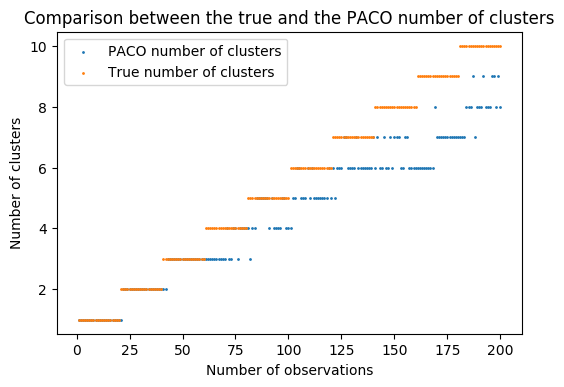

In [45]:
p1 = plt.scatter([t+1 for t in range(T)],nb_of_clusters_2, s=1)
p2 = plt.scatter([t+1 for t in range(T)],[np.floor(t/20)+1 for t in range(T)], s=1)

plt.title('Comparison between the true and the PACO number of clusters')
plt.xlabel('Number of observations')
plt.ylabel('Number of clusters')
plt.legend([p1, p2], ["PACO number of clusters", "True number of clusters"])
plt.show()

$ECL = \sum\limits_{t=1}^{T}E_{\hat{\rho}_1, \hat{\rho}_2,...,\hat{\rho}_t}l(\hat{c}_t,x_t)$

$OCL = \inf\limits_{c\in \mathcal{C}(k*,R)}\sum\limits_{t=1}^{T}l(c,x_t)$

Le prédicteur Oracle correspond ici au k-means utilisé avec le bon nombre de clusters.

In [18]:
true_clusters = np.array([np.floor(t/20)+1 for t in range(T)])

In [20]:
oracle_loss = []
for i in range(T):
    kmeans = KMeans(n_clusters=int(true_clusters[i]), random_state=0, max_iter=10).fit(model[:i+1])
    centers__ = kmeans.cluster_centers_
    intermediate_loss = []
    for n in range(i):
        intermediate_loss.append(instantaneous_loss(centers__, model[n]))
    oracle_loss.append(np.sum(intermediate_loss))

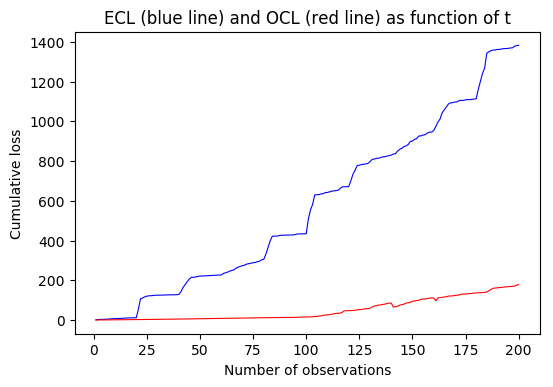

In [21]:
x = [t+1 for t in range(T)]

plt.plot(x, np.cumsum(predicted_loss_2), 'blue', linewidth=.8)
#empirical_upper_band = np.cumsum(predicted_loss_2)+np.array([np.sqrt(np.var(np.cumsum(predicted_loss_2)[:i])) for i in range(T)])
#empirical_lower_band = np.cumsum(predicted_loss_2)-np.array([np.sqrt(np.var(np.cumsum(predicted_loss_2)[:i])) for i in range(T)])
#plt.plot(x, empirical_upper_band, 'blue', linestyle='--', linewidth=.8)
#plt.plot(x, empirical_lower_band, 'blue', linestyle='--', linewidth=.8)
#plt.fill_between(x, empirical_upper_band, empirical_lower_band, color='blue', alpha='0.5')

plt.plot(x, oracle_loss, 'red', linewidth=.8)
#oracle_upper_band = oracle_loss+1.96*np.array([np.sqrt(np.var(oracle_loss[:i])) for i in range(T)])
#oracle_lower_band = oracle_loss-1.96*np.array([np.sqrt(np.var(oracle_loss[:i])) for i in range(T)])
#plt.plot(x, oracle_upper_band, 'red', linestyle='--', linewidth=.8)
#plt.plot(x, oracle_lower_band, 'red', linestyle='--', linewidth=.8)
#plt.fill_between(x, oracle_upper_band, oracle_lower_band, color='red', alpha='0.5')


plt.title('ECL (blue line) and OCL (red line) as function of t')
plt.xlabel('Number of observations')
plt.ylabel('Cumulative loss')
plt.show()

/Users/Linger/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


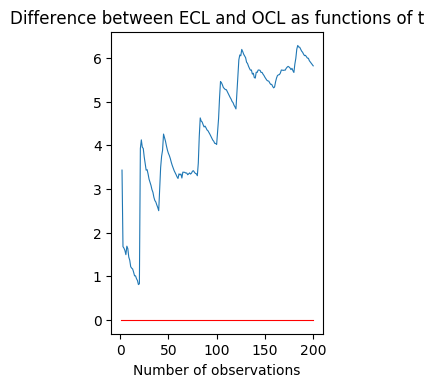

/Users/Linger/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide


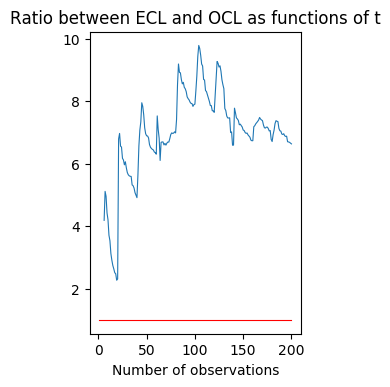

In [130]:
Diff = np.cumsum(predicted_loss_2) - oracle_loss
plt.subplot(1, 2, 1)
plt.plot([t+1 for t in range(T)], [Diff[i]/i for i in range(T)], linewidth=.8)
plt.plot([t+1 for t in range(T)], [0 for i in range(T)], 'red', linewidth=.8)
plt.title('Difference between ECL and OCL as functions of t')
plt.xlabel('Number of observations')
plt.show()

Ratio = np.cumsum(predicted_loss_2)/oracle_loss
plt.subplot(1, 2, 2)
plt.plot([t+1 for t in range(5, T)], [Ratio[i] for i in range(5, T)], linewidth=.8)
plt.plot([t+1 for t in range(T)], [1 for i in range(T)], 'red', linewidth=.8)
plt.title('Ratio between ECL and OCL as functions of t')
plt.xlabel('Number of observations')
plt.show()

3 ] __Limitations__: En pratique il n'est pas implémentable en grande dimension

Lorsque l'on a trop de features, le calcul de runiform_ball(n, d, R) est super long. Pour une dimension de 15 (i.e. d = 15), le temps nécessaire au calcul de runiform_ball(5000, 15, R) est de <refaire la simulation mais c'est plus de 4 minutes> <-- Cette méthode de clustering en ligne ne peut pas être utilisée en grande dimension. L'idée de restreindre les centroids à une hyperball est bonne mais est très longue computationnellement quand la dimension des données augmente.

In [ ]:
import time
durations = []
for i in range(12):
    print(i)
    start = time.time()
    runiform_ball(5000, i+1, 2)
    stop = time.time()
    durations.append(stop-start)

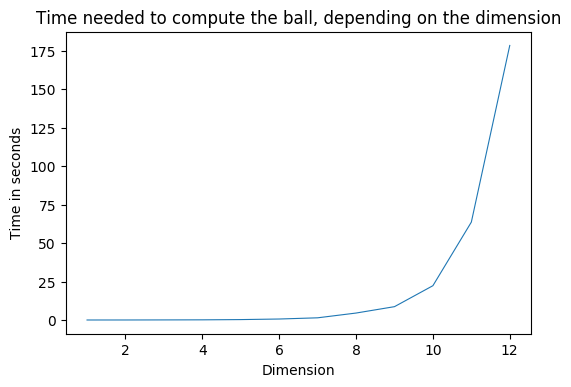

In [110]:
plt.plot([i+1 for i in range(12)], durations, linewidth=.8)
plt.title('Time needed to compute the ball, depending on the dimension')
plt.xlabel('Dimension')
plt.ylabel('Time in seconds')